In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import plotly
import plotly.graph_objects as go
import plotly.express as px

In [3]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

In [4]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools

RDKit WARNING: [20:31:07] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:
# Set the default renderer to png as the data is huge and overwhelms the Javascript renderers
pio.renderers.default = 'png'

# All datasets (excluding Mpro-x1093)

In [6]:
df = pd.read_csv('all_data_16.csv.gz')
df.shape

(665216, 24)

In [7]:
df.dtypes

REC                             int64
Name                           object
TransFSScore                  float64
SCORE                         float64
SCORE.norm                    float64
Max_SuCOS_Score               float64
Max_SuCOS_FeatureMap_Score    float64
Max_SuCOS_Protrude_Score      float64
Max_SuCOS_Index                object
Cum_SuCOS_Score               float64
Cum_SuCOS_FeatureMap_Score    float64
Cum_SuCOS_Protrude_Score      float64
logP                          float64
Rotatable bonds               float64
distance1                     float64
distance2                     float64
distance3                     float64
distance4                     float64
distance5                     float64
distance6                     float64
distance7                     float64
distance8                     float64
distance9                     float64
Target                         object
dtype: object

These are the columns.
Other properties that are calculated but not included in this dataset are:
- Molecular weight
- Hydrogen-bond donors
- Hydrogen-bond acceptors
- Polar surface area
- Molecular refractivity
- Number of rings
- Number of heavy atoms

In [8]:
df.columns

Index(['REC', 'Name', 'TransFSScore', 'SCORE', 'SCORE.norm', 'Max_SuCOS_Score',
       'Max_SuCOS_FeatureMap_Score', 'Max_SuCOS_Protrude_Score',
       'Max_SuCOS_Index', 'Cum_SuCOS_Score', 'Cum_SuCOS_FeatureMap_Score',
       'Cum_SuCOS_Protrude_Score', 'logP', 'Rotatable bonds', 'distance1',
       'distance2', 'distance3', 'distance4', 'distance5', 'distance6',
       'distance7', 'distance8', 'distance9', 'Target'],
      dtype='object')

## Things to do with the data frame
- create new dataframe with only the top scoring pose for each molecule
- create filters based on scores and molecular properties

## Normalised docking scores

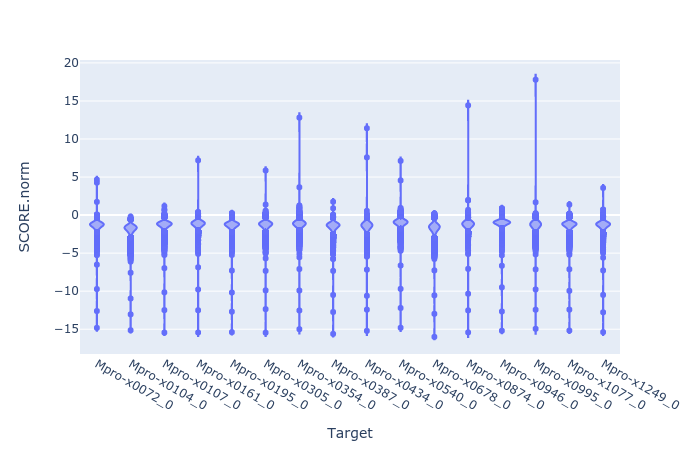

In [9]:
fig = px.violin(df, x="Target", y="SCORE.norm")
fig.show()

## TransFS scores

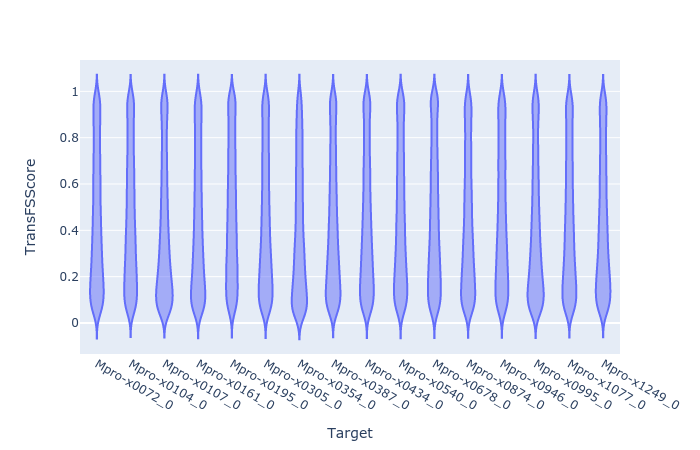

In [10]:
fig = px.violin(df, x="Target", y="TransFSScore")
fig.show()

## Cumulative SuCOS scores

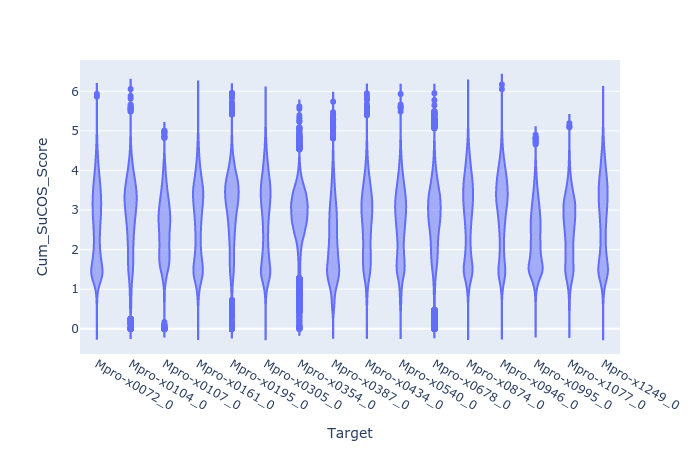

In [11]:
fig = px.violin(df, x="Target", y="Cum_SuCOS_Score")
fig.show()

## Max SuCOS scores

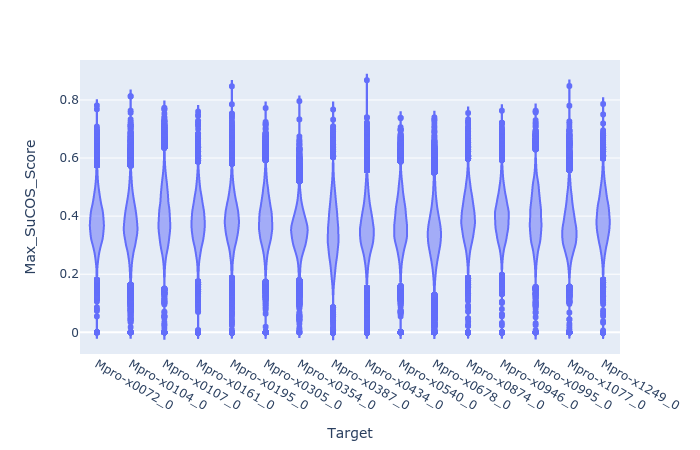

In [12]:
fig = px.violin(df, x="Target", y="Max_SuCOS_Score")
fig.show()

## logP distribution

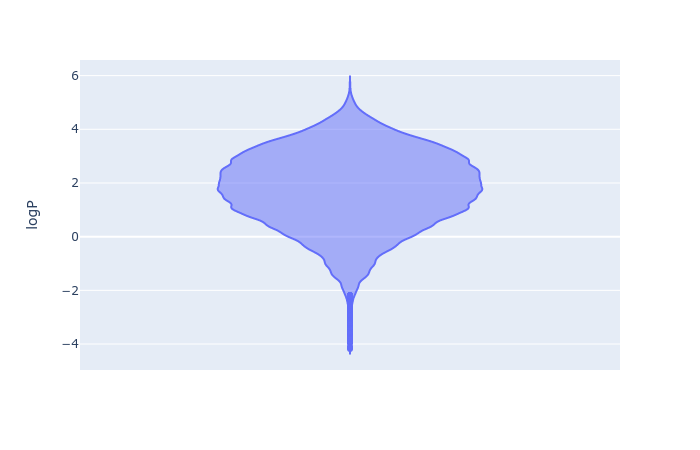

In [13]:
fig = px.violin(df, y="logP")
fig.show()
# looks quite reasonable

## rotatable bond distribution

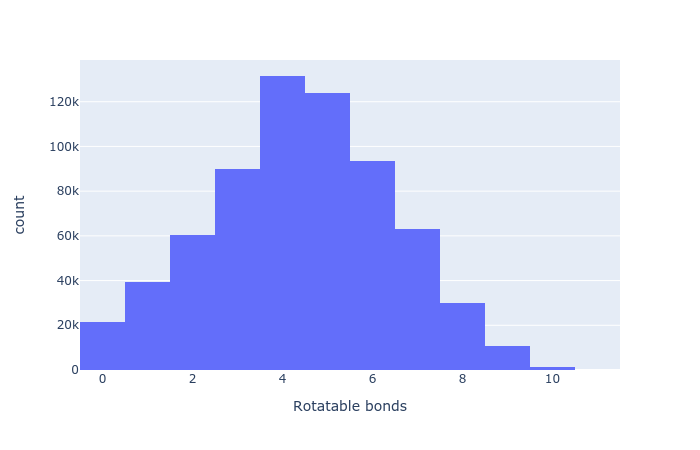

In [14]:
fig = px.histogram(df, x="Rotatable bonds")
fig.show()
# a few to many with lots of rot bonds, but care needed as different tools have different 
# ideas of what is a rotatable bond.

## Distances

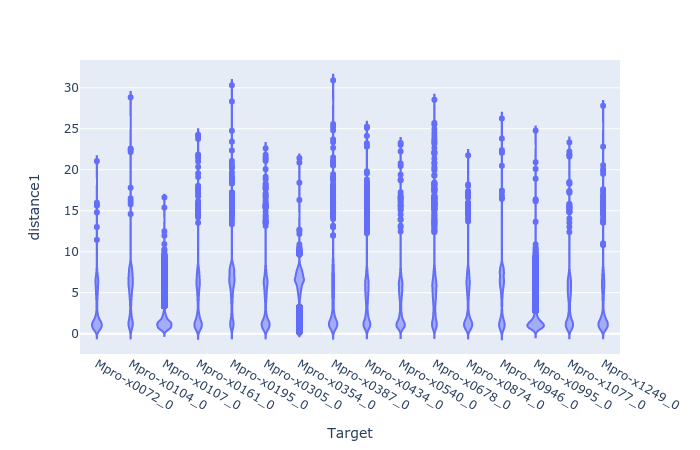

In [15]:
fig = px.violin(df, x="Target", y="distance1")
fig.show()

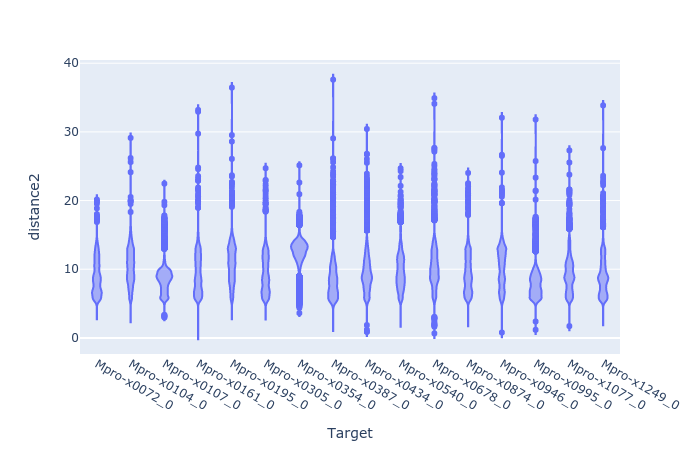

In [16]:
fig = px.violin(df, x="Target", y="distance2")
fig.show()

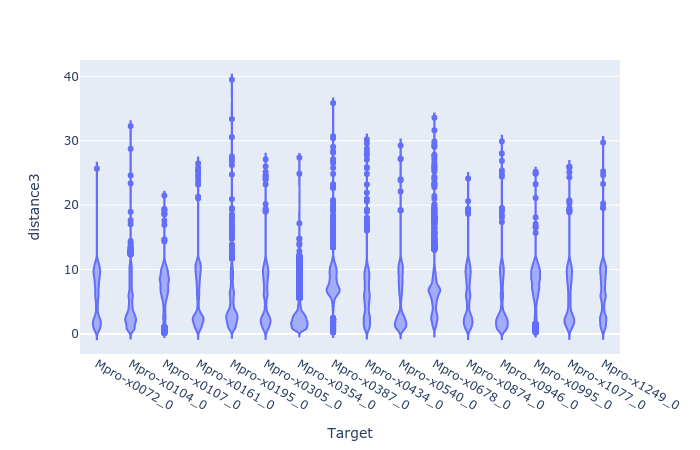

In [17]:
fig = px.violin(df, x="Target", y="distance3")
fig.show()

In [ ]:
fig = px.violin(df, x="Target", y="distance4")
fig.show()

In [ ]:
fig = px.violin(df, x="Target", y="distance5")
fig.show()

In [ ]:
fig = px.violin(df, x="Target", y="distance6")
fig.show()

In [ ]:
fig = px.violin(df, x="Target", y="distance7")
fig.show()

In [ ]:
fig = px.violin(df, x="Target", y="distance8")
fig.show()

In [ ]:
fig = px.violin(df, x="Target", y="distance9")
fig.show()

## Distance measures

In [ ]:
# plot all distances

fig = go.Figure()
for i in range(1,10):
    k = "distance" + str(i)
    xs = []
    for i in range(500):
        xs.append(k)
    fig.add_trace(go.Violin(x=xs, y=df[k], showlegend=False))
fig.show()

# Merging and sorting

In [ ]:
df1 = df.groupby(["Name"])

In [ ]:
df12 = df1.apply(lambda x: x.sort_values(['TransFSScore'], ascending=False))
df13 = df12.reset_index(drop=True)
df14 = df13.groupby('Name').head(1)
df_merged = df14.sort_values(by='TransFSScore', ascending=False)
df_merged.head()

# Filtering

Here is one approach to filtering.
We apply a series of filters to the data to be left with 'top scoring' molecules.
Beauty is in the eye of the beholder so try different filters.

The filters are applied in series.

In [ ]:
df_merged.shape

In [ ]:
# filter by TransFS score
df_toptfs = df_merged[df_merged['TransFSScore'] >= 0.9]
df_toptfs.shape

In [ ]:
# filter out molecules that are too flexible
df_toprotb = df_toptfs[df_toptfs["Rotatable bonds"] <= 6]
df_toprotb.shape

In [ ]:
# filter by SuCOS score. Here we use Cum_SuCOS_Score but also consider using the 5 other SuCOS scores.
df_topsucos = df_toprotb[df_toprotb["Cum_SuCOS_Score"] >= 3]
df_topsucos.shape

In [ ]:
# filter by normalised docking score. We use a pretty loose filter here as we know docking scores are not 
# that relaible, but we might as well throw out the ones that docking says are really bad. 
df_toprdock = df_topsucos[df_topsucos["SCORE.norm"] <= -1.0]
df_toprdock.dtypes

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df_toprdock,'Name','Molecule')
df_toprdock.dtypes

In [ ]:
# reorder the Molecule column
cols = df_toprdock.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_toprdock = df_toprdock[cols]

In [ ]:
df_toprdock.head(10)

# 500 Filtered best scoring hits
These are the top 500 TransFSScore scoring hits.
These were filterd by Bjoern. We should be able o filter dynamically on the big data frame.

In [ ]:
df2 = pd.read_csv('Final_3D_hit-structures_distances.csv.gz')
df2.dtypes

In [ ]:
df2.head()

In [ ]:
# for a single distance
fig = px.violin(df2, y="distance1")
fig.show()

In [ ]:
# plot all distances
#
# nothing is occupying site 2 and site 9 is poorly occupied.
# The other sites are well occupied.

fig = go.Figure()
for i in range(1,10):
    k = "distance" + str(i)
    xs = []
    for i in range(500):
        xs.append(k)
    fig.add_trace(go.Violin(x=xs, y=df2[k], showlegend=False))
fig.show(renderer='plotly_mimetype+notebook')


In [ ]:
# TransFS scores within 2A of a particular point
dist = 'distance1'
close_df = df2[df2[dist] < 2.0]
close_df.shape

In [ ]:
fig = px.box(close_df, y='TransFSScore')
fig.show()

In [ ]:
# distribution of scores of ligands grouped by being <2A from each of the points

fig = go.Figure()
for i in [1,3,4,5,7,8,9]:
    k = "distance" + str(i)
    dfx = df2[df2[k] < 2.0]

    xs = []
    for i in range(dfx.shape[0]):
        xs.append(k)
    fig.add_trace(go.Violin(x=xs, y=dfx['Cum_SuCOS_Score'], box_visible=True, showlegend=False))
fig.show(renderer='plotly_mimetype+notebook')

In [ ]:
# Distribuion of SuCOS scores
fig = px.violin(df2, y="Max_SuCOS_Score")
fig.show()

Parallel coordinate plot of the distances for these top 500 scores.

It looks like distance 5 and 6 are almost identical?

A pose that occupies a site will be towards the bottom of the plot.

Filter the plot by interacting with the axes.

In [ ]:
fig = px.parallel_coordinates(df2, color="Max_SuCOS_Score", 
                dimensions=['distance1','distance2','distance3','distance4','distance5','distance6',
                            'distance7','distance8','distance9'],              
                color_continuous_scale=px.colors.diverging.Tealrose,
                color_continuous_midpoint=0.5)
fig.show(renderer='plotly_mimetype+notebook')

## Incorporating tox data from Enalos
Enalos have run some inital predictions on the top 500 data and are willing to provide further data

In [ ]:
df_enalos = pd.read_csv('Enalos_data.csv.gz')
df_enalos = df_enalos.drop(columns=['SMILES', 'InChI', 'InChIkey'])
df_enalos = df_enalos.rename(columns={"original SMILES": "SMILES"})
df_enalos.head()

In [ ]:
df3 = df2.rename(columns={"Name": "SMILES"})
merged = pd.merge(df3, df_enalos, on='SMILES')
merged.head()

Now we have some tox predictors in our set